In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

log = pd.read_csv('data/log.csv')
log.head()

,case,event,startTime,completeTime,office_u,variantindex,NumberComplaints,gender,office_w,variant,...,complainttopic_en,vhost,complainttopicid,ipid,NumberQuestionsSoFar,questionsubtheme_en,questionsubthemeid,complainttheme_en,complaintsubtheme_en,service_detail
0,1445,NaN,2015/08/07 10:51:41.000,2015/08/07 10:51:41.000,296,2.0,0,M,291,Variant 2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1445,Visit page mijn_cv,2015/08/07 10:52:27.000,2015/08/07 10:52:27.000,296,2.0,0,M,291,Variant 2,...,NaN,digid.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1445,Visit page home,2015/08/07 10:53:08.000,2015/08/07 10:53:08.000,296,2.0,0,M,291,Variant 2,...,NaN,www.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
3,1445,Visit page mijn_cv,2015/08/07 10:53:14.000,2015/08/07 10:53:14.000,296,2.0,0,M,291,Variant 2,...,NaN,digid.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN
4,1445,Visit page home,2015/08/07 10:53:38.000,2015/08/15 19:05:12.000,296,2.0,0,M,291,Variant 2,...,NaN,www.werk.nl,NaN,1048748.0,0.0,NaN,NaN,NaN,NaN,NaN


<h2>  Data Quality </h2>

Lets start by checking the NaN counts. Are there columns with many missing values?

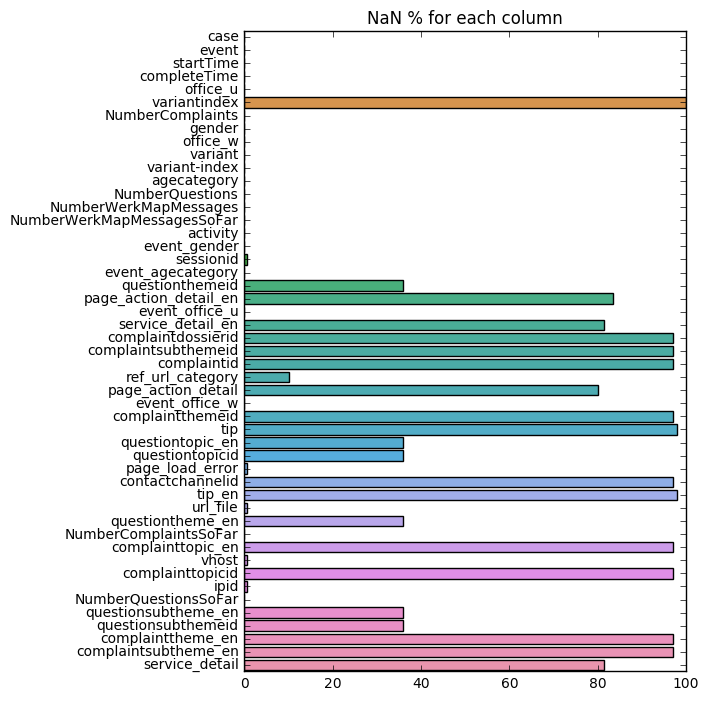

In [2]:
null = log.isnull().sum() * 100 / len(log)
null.head()

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(5.7, 8.27)

sns.barplot(x=null, y=null.index).set_title('NaN % for each column')
plt.show()

<h2> Unique values </h2>

Lets now look at the distribution of values in each column. This can provide an insight into their meaning.

In [3]:
log.apply(pd.Series.nunique)

case                            4226
event                            246
startTime                     481325
completeTime                  481324
office_u                          13
variantindex                       1
NumberComplaints                   6
gender                             2
office_w                          40
variant                         4225
variant-index                   4224
agecategory                        4
NumberQuestions                   40
NumberWerkMapMessages             37
NumberWerkMapMessagesSoFar        54
activity                         246
event_gender                       2
sessionid                     106221
event_agecategory                  4
questionthemeid                   14
page_action_detail_en             20
event_office_u                    13
service_detail_en                 15
complaintdossierid               256
complaintsubthemeid                5
complaintid                      289
ref_url_category                   9
p

<b> Some of these numbers are interesting. Specifically the following conclusions can be drawn: </b>

- The case column refers to the signed in users. There are **4226 unique users** in our database


- The sessionid refers to the internet session. There are **106221 different sessions**, therefore each user visited our site **25 times on average** 


- There are **246 different events**  (all of them referring to specific URL visits). This info is recorded twice (**activity and event columns seem to be the same**). We can therefore safely remove one of them.


- Ages are binned into **4 categories** , probably for anonimization purposes.

<h3> Lets look with some more detail into the different values for interesting features </h3>

In [18]:
# Events without an event type are pretty useless so we might as well drop them
log.dropna(axis=0, subset=['event'], inplace=True)

events = log['event'].unique()
not_page_visits = [event for event in events if not event.startswith('Visit page')]
not_page_visits

['Question', 'Werkmap message', 'File Complaint']

<h3> Almost all events are page visits! </h3>

As we can see, out of 246 unique events, 243 are visits of specific URL pages. The 3 remaining are very important for our case since we are mostly interested in traces that lead to a call, a question or a complaint. 

<b> Lets take a closer look at this events. </b>

In [33]:
def event_percentage(event):
    return len(log.loc[log['event'] == event]) * 100 / len(log)

for event in not_page_visits:
    print('{:.2f}% of records refer to a {}'.format(event_percentage(event), event))

4.14% of records refer to a Question
2.31% of records refer to a Werkmap message
0.06% of records refer to a File Complaint
